In [48]:
import csv
import re
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import style, colors
import matplotlib.patches as patches
from matplotlib import gridspec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist


# matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. color scheme

In [3]:
# choose color from here
# http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4

In [140]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
df_clrs = pd.read_csv(f, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]

,0,1
0,HPV16,#7F3B08
1,HPV31,#B35806


('HPV16', '#7F3B08')

In [117]:
# color_dict

In [92]:
df_clrs.head(2)

,0,1
0,HPV16,#7F3B08
1,HPV31,#B35806


23         Wild Type
24               NaN
25                G1
26                G2
27                G3
28           unknown
29               <45
30             45-65
31               >65
32        Frameshift
33          Multiple
34    Non-synonymous
35      Start gained
36       Stop gained
37        Synonymous
Name: 0, dtype: object

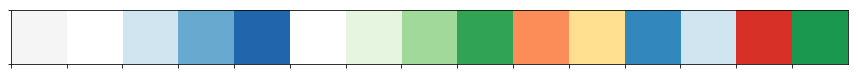

In [141]:
all_colors = [ "purple", "#E69F00",'pink', 'gray',"#009E73","#56B4E9","#377EB8",
        "#E41A1C","#F0E442",'black',"#D55E00","#CC79A7", "#D55E00","#CC79A7"]
sns.palplot(df_clrs[1][-15:])
df_clrs[0][-15:]

In [89]:
for i in np.unique(df.values.ravel().astype(str))[20:]:
    print(i)

Adeno
Adenosquamous
Frameshift
Multiple
Negative
Neuroendocrine
Non-synonymous
Positive
Squamous
Start gained
Stop gained
Synonymous
nan


# 2. input matrix

In [140]:
# f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/mutations_for_oncoprint_123_patients.txt'
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details.txt'
df = pd.read_csv(f1, sep='\t', index_col='percentage')
df.head(3)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447
percentage,,,,,,,,,,,,,,,,,,,,,
HIV_status(102%),Positive,Negative,Positive,Negative,Negative,Negative,Negative,Positive,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
Putative_histology(102%),Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adeno,Squamous,Squamous
CASP8(7%),Frameshift,NaN,NaN,NaN,NaN,Stop gained,NaN,NaN,Non-synonymous,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
# df.isnull().sort_values(df.index.tolist(), axis=1, ascending=True)

In [142]:
# df.sort_values(df.index.tolist(), axis=1, ascending=False, na_position='last').head(10)

In [143]:
dftmp = pd.DataFrame([list(np.array(re.split('\(|\)', i))[[0,1]]) for i in df.index.tolist()], columns=['gene', 'mfreq'])

In [144]:
df['gene'] = dftmp.gene.tolist()
df['mfreq'] = dftmp.mfreq.tolist()

In [145]:
df['mfreq'] = df['mfreq'].apply(lambda x: int(x.replace('%', '')))

In [146]:
df.head()

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,gene,mfreq
percentage,,,,,,,,,,,,,,,,,,,,,
HIV_status(102%),Positive,Negative,Positive,Negative,Negative,Negative,Negative,Positive,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,HIV_status,102
Putative_histology(102%),Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Squamous,Squamous,Squamous,Squamous,Squamous,Adeno,Squamous,Squamous,Putative_histology,102
CASP8(7%),Frameshift,NaN,NaN,NaN,NaN,Stop gained,NaN,NaN,Non-synonymous,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASP8,7
FAT1(19%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stop gained,NaN,...,Frameshift,Multiple,NaN,Non-synonymous,NaN,NaN,NaN,NaN,FAT1,19
FBXW7(10%),NaN,NaN,NaN,Non-synonymous,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Non-synonymous,NaN,Frameshift,NaN,NaN,NaN,NaN,FBXW7,10


In [147]:
df = df.sort_values('mfreq', ascending=False)

In [148]:
df.set_index('gene', drop=True, inplace=True)

In [149]:
df.head()

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,mfreq
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,Positive,Negative,Positive,Negative,Negative,Negative,Negative,Positive,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,102
Putative_histology,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adeno,Squamous,Squamous,102
PIK3CA,Non-synonymous,Non-synonymous,NaN,NaN,NaN,Non-synonymous,Non-synonymous,NaN,Non-synonymous,NaN,...,NaN,NaN,Non-synonymous,NaN,NaN,NaN,NaN,NaN,Non-synonymous,35
FAT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stop gained,NaN,...,NaN,Frameshift,Multiple,NaN,Non-synonymous,NaN,NaN,NaN,NaN,19
MLL2,NaN,Stop gained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Frameshift,NaN,NaN,NaN,NaN,15


In [150]:
assert ('HTMCP-03-06-02061' in df.columns) == False

In [151]:
# df[df.columns[0:123]].sort_values(df.index.tolist(), axis=1) this does not work?

In [152]:
dfa = (df.loc['HIV_status',] == 'Negative') 
dfa = df[dfa[dfa].index]
df['hiv_neg_mfreq'] = (dfa.notnull().sum(axis=1)/dfa.shape[1]*100).astype(int)
dfb = (df.loc['HIV_status',] == 'Positive') 
dfb = df[dfb[dfb].index]
df['hiv_pos_mfreq'] = (dfb.notnull().sum(axis=1)/dfb.shape[1]*100).astype(int)

In [153]:
df.head(10)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,mfreq,hiv_neg_mfreq,hiv_pos_mfreq
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,Positive,Negative,Positive,Negative,Negative,Negative,Negative,Positive,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,102,100,100
Putative_histology,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Squamous,Squamous,Squamous,Squamous,Adeno,Squamous,Squamous,102,100,100
PIK3CA,Non-synonymous,Non-synonymous,NaN,NaN,NaN,Non-synonymous,Non-synonymous,NaN,Non-synonymous,NaN,...,Non-synonymous,NaN,NaN,NaN,NaN,NaN,Non-synonymous,35,44,28
FAT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stop gained,NaN,...,Multiple,NaN,Non-synonymous,NaN,NaN,NaN,NaN,19,22,16
MLL2,NaN,Stop gained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Frameshift,NaN,NaN,NaN,NaN,15,22,9
FBXW7,NaN,NaN,NaN,Non-synonymous,NaN,NaN,NaN,NaN,NaN,NaN,...,Non-synonymous,NaN,Frameshift,NaN,NaN,NaN,NaN,10,13,8
CASP8,Frameshift,NaN,NaN,NaN,NaN,Stop gained,NaN,NaN,Non-synonymous,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,6,6
SLC35G5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Multiple,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,2,9
MAPK1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Non-synonymous,NaN,NaN,NaN,NaN,NaN,NaN,5,4,5


In [154]:
df.loc['HIV_status',].unique()

array(['Positive', 'Negative', 102, 100], dtype=object)

In [155]:
df = df.sort_values(df.index.tolist(), axis=1)

In [156]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency.txt'
df.to_csv(f2)

# 3. plot oncoprint

In [25]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency.txt'
df = pd.read_csv(f2, index_col='gene')
df.head()

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02075,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02326,HTMCP-03-06-02203,HTMCP-03-06-02176,HTMCP-03-06-02047,...,HTMCP-03-06-02225,HTMCP-03-06-02259,HTMCP-03-06-02330,HTMCP-03-06-02377,HTMCP-03-06-02393,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02434,HTMCP-03-06-02437,HTMCP-03-06-02442
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
Putative_histology,100,100,102,Adeno,Adeno,Adeno,Adeno,Adenosquamous,Adenosquamous,Neuroendocrine,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
PIK3CA,28,44,35,Non-synonymous,NaN,NaN,NaN,Non-synonymous,NaN,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1,16,22,19,NaN,Synonymous,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL2,9,22,15,NaN,NaN,Frameshift,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# sort gene based on frequency
df = df.sort_values('mfreq', ascending=False)

In [27]:
def sort_patients(dfxx):
    # exhausitive binary sort
    i = 1e18
    arr = []
    for ix, row in dfxx.iterrows():
        arr.append(row * i)
#         print(i)
        i = i/10
    sorted_pats = pd.DataFrame(arr).sum().sort_values(ascending=False).index.tolist()
#     print(pd.DataFrame(arr).sum().sort_values(ascending=False))
    return sorted_pats

In [28]:
# sort patients based on if a gene is mutated or not in the order of genes
dfx = df[[i for i in df.columns if i.startswith('HTMCP')]]
dfy = dfx.drop(['HIV_status','Putative_histology' ])
dfq = dfx.loc[['HIV_status','Putative_histology'],]
dfz = dfy.notnull()
dfxx = pd.concat([dfq, dfz]).drop('Putative_histology').replace('Positive', True).replace('Negative', False)
dfxx.head()

,HTMCP-03-06-02075,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02326,HTMCP-03-06-02203,HTMCP-03-06-02176,HTMCP-03-06-02047,HTMCP-03-06-02214,HTMCP-03-06-02074,HTMCP-03-06-02215,...,HTMCP-03-06-02225,HTMCP-03-06-02259,HTMCP-03-06-02330,HTMCP-03-06-02377,HTMCP-03-06-02393,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02434,HTMCP-03-06-02437,HTMCP-03-06-02442
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
PIK3CA,True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FAT1,False,True,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
MLL2,False,False,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
FBXW7,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [29]:
sorted_pats = sort_patients(dfxx)

In [30]:
sorted_patients = ['hiv_pos_mfreq', 'hiv_neg_mfreq', 'mfreq',] + sorted_pats
df = df[sorted_patients]

In [31]:
sorted_pats[:3]

['HTMCP-03-06-02260', 'HTMCP-03-06-02428', 'HTMCP-03-06-02139']

# 4. get coding mutation rate per mb

In [32]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/coding_mutation_rate.txt'
# df2.to_csv(of, sep='\t', index=False)
df2 = pd.read_csv(of, sep='\t', index_col='patient')
df2.head(2)
df2.shape

(123, 47)

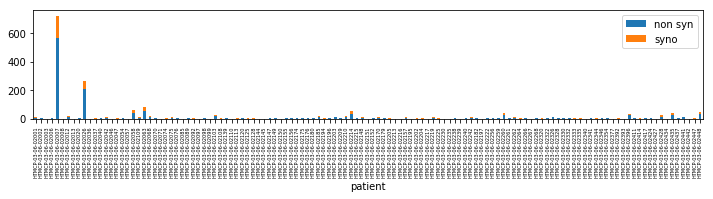

In [33]:
fig = plt.figure(facecolor='white',  figsize=(12,2))
ax = fig.add_subplot(111, facecolor='white')
df2[['nsyno_mut_rate', 'syno_mut_rate']].plot.bar(stacked=True, ax=ax)
# ax.set_ylim(0,100)
_ = ax.set_xticklabels(df2.index.tolist(), fontsize=5)
_ = ax.legend(labels=['non syn', 'syno'])

In [34]:
df_cov = (df2[['tumor_grade', 'age_at_diagnosis']].T)[sorted_pats]

In [35]:
df_cov.notnull().sum(axis=1)

tumor_grade         88
age_at_diagnosis    89
dtype: int64

In [36]:
# mutation rate significance between hiv+ and -

In [37]:
dftmp = df2[['HIV_status', 'age_at_diagnosis']].dropna()

In [38]:
hiv_pos = dftmp.query('HIV_status=="{}"'.format('Positive'))['age_at_diagnosis']
hiv_neg = dftmp.query('HIV_status=="{}"'.format('Negative'))['age_at_diagnosis']

In [39]:
sts, p = ss.mannwhitneyu(hiv_pos, hiv_neg, use_continuity=True, alternative=None)
p

3.1343840609272565e-06

In [40]:
ages = []
for n in df_cov.loc['age_at_diagnosis', ].tolist():
#     print(n)
    n = float(n)
    if n <= 45:
        gr = '<45'
    elif n>45 and n<=65:
        gr = '45-65'
    elif n > 65:
        gr = '>65'
    else:
        gr = 'unknown'
    ages.append(gr)
df_cov.loc['age_at_diagnosis', ] = ages

In [41]:
df_cov = df_cov.fillna('unknown')

In [42]:
df_cov.loc['tumor_grade', ].unique()

array(['G2', 'unknown', 'G3', 'G1'], dtype=object)

In [43]:
df_cov.loc['age_at_diagnosis', ].unique()

array(['<45', 'unknown', '45-65', '>65'], dtype=object)

In [44]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    if 'top' in spines:
        ax.xaxis.set_ticks_position('top')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [46]:
# add mutation frequency into the gene label
df.head(2)
df = df.reset_index()
df['xxxx'] = df.apply(lambda x: ''.join([str(x[0]), '(', str(x[3]), '%)']), axis=1)
df.set_index('gene', inplace=True)
df.loc['HIV_status', 'xxxx'] = 'HIV_status'
df.loc['Putative_histology', 'xxxx' ] = 'Putative_histology'
df = df.set_index('xxxx', drop=True)

In [47]:
df.head(2)

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,...,HTMCP-03-06-02326,HTMCP-03-06-02008,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02185,HTMCP-03-06-02194,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02332,HTMCP-03-06-02037
xxxx,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,100,100,102,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous


In [49]:
np.unique(df.values.ravel().astype(str))

array(['1', '10', '100', '102', '13', '15', '16', '19', '2', '22', '28',
       '3', '35', '4', '44', '5', '6', '7', '8', '9', 'Adeno',
       'Adenosquamous', 'Frameshift', 'Multiple', 'Negative',
       'Neuroendocrine', 'Non-synonymous', 'Positive', 'Squamous',
       'Start gained', 'Stop gained', 'Synonymous', 'nan'], dtype='<U14')

In [71]:
df2.head(2)

,snv_counts,indel_counts,snv_sns_counts,indel_sns_counts,snv_syno_counts,indel_syno_counts,strelka_mutations,strelka_coding_mutations,strelka_syno_mutations,strelka_nsyno_mutations,...,patient_id,pregnancies_count_induced_abortion,pregnancies_count_miscarriage,tobacco_smoking_history_indicator,total_pregnancy_count,tumor_grade,weight_kg_at_diagnosis,syno_mut_rate,nsyno_mut_rate,total
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,25732,1242,329,11,102,0,26974,340,102,238,...,2001.0,NaN,1.0,1.0,6.0,G2,44.5,3.560476,8.307778,11.868255
HTMCP-03-06-02002,15964,697,225,2,72,0,16661,227,72,155,...,2002.0,3.0,NaN,1.0,11.0,G3,70.2,2.513277,5.410528,7.923805


In [80]:
df.head(2)
df.shape
assert len(patients)+3==df.shape[1]

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,...,HTMCP-03-06-02326,HTMCP-03-06-02008,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02185,HTMCP-03-06-02194,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02332,HTMCP-03-06-02037
xxxx,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,100,100,102,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous


(14, 121)

['Adeno', 'Squamous', 'Neuroendocrine', 'Adenosquamous', 'Negative', 'Positive', 'Non-synonymous', 'Frameshift', 'Stop gained', 'Start gained', 'Synonymous', 'Multiple']
####### {'HPV16': '#7F3B08', 'HPV31': '#B35806', 'HPV33': '#E08214', 'HPV35': '#FDB863', 'HPV52': '#FEE0B6', 'HPV58': '#F7F7F7', 'HPV18': '#2D004B', 'HPV45': '#542788', 'HPV68': '#8073AC', 'HPV59': '#B2ABD2', 'HPV82': '#252525', 'HPV51': '#525252', 'HPV9': '#737373', 'HPV69': '#969696', 'HPV30': '#BDBDBD', 'HPV26': '#D9D9D9', 'Positive': '#018571', 'Negative': '#80cdc1', 'Squamous': '#d73027', 'Neuroendocrine': '#e0f3f8', 'Adenosquamous': '#91bfdb', 'Adeno': '#4575b4', 'Mutated': 'black', 'Wild Type': '#f5f5f5', nan: 'white', 'G1': '#d1e5f0', 'G2': '#67a9cf', 'G3': '#2166ac', 'unknown': 'white', '<45': '#e5f5e0', '45-65': '#a1d99b', '>65': '#31a354', 'Frameshift': '#fc8d59', 'Multiple': '#fee090', 'Non-synonymous': '#3288bd', 'Start gained': '#d1e5f0', 'Stop gained': '#d73027', 'Synonymous': '#1a9850'}
*******         

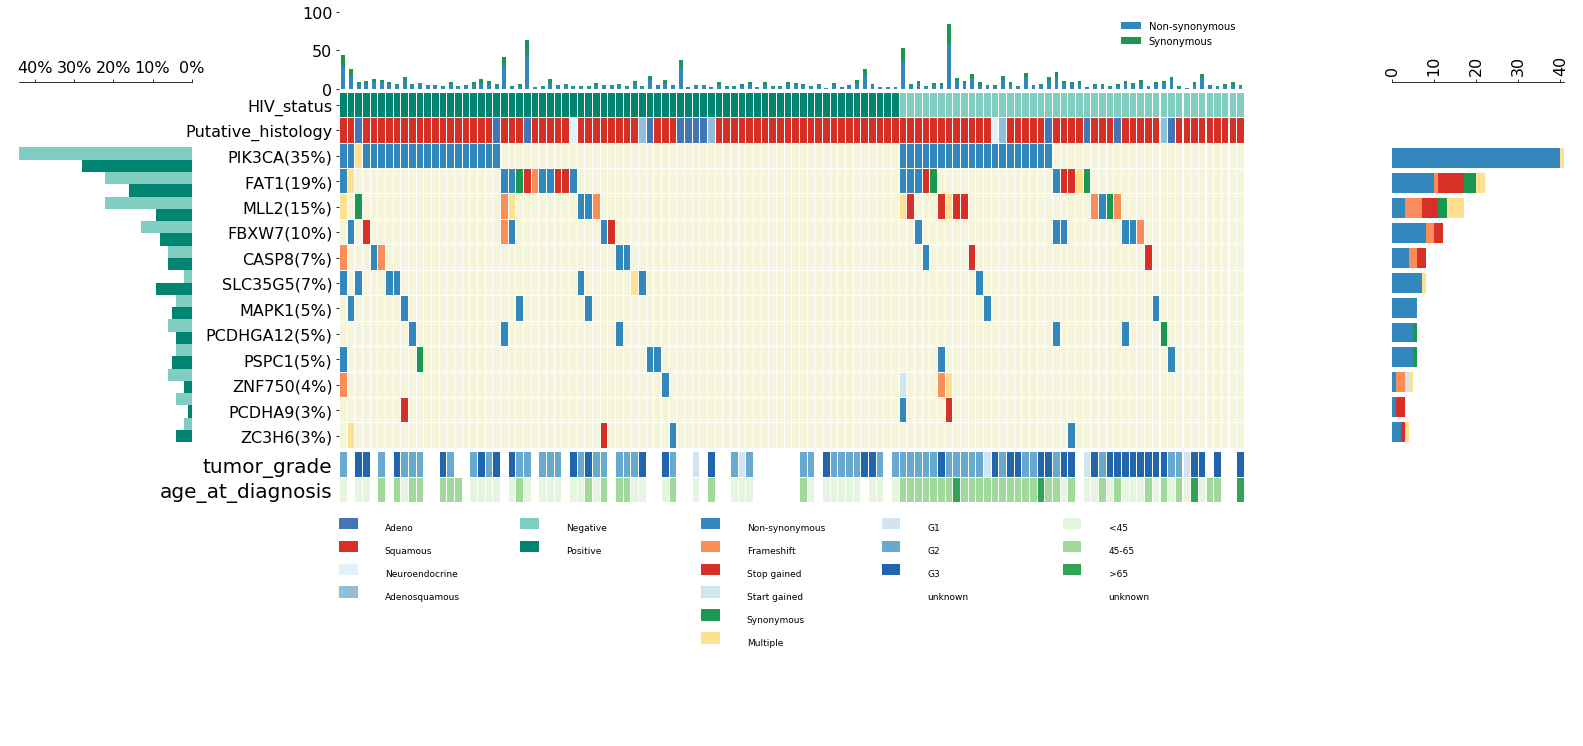

In [144]:
# to reduce blank space for specific subplots not all, reference to this link
# https://stackoverflow.com/questions/31484273/spacing-between-some-subplots-but-not-all
# df2: mutation rate
# df: mutation matrix
# patients: ordered columns
    
nrows = df.shape[0]    
fig = plt.figure(figsize=(28,.95*nrows), facecolor='white')
gs = gridspec.GridSpec(4, 3,                            
                       width_ratios=[3,15,3], 
                       height_ratios=[3,14,2,9],
                       wspace=0.35, # horizontal space
                       hspace=0.02  # vertical space
                      )
# grid 0  1  2  3
#      4  5  6  7
#      8  9  10 11
all_colors = [ "purple", "#E69F00",'pink', 'gray',"#009E73","#56B4E9","#377EB8",
        "#E41A1C","#F0E442",'black',"#D55E00","#CC79A7", "#D55E00","#CC79A7"]
patients = [p for p in df.columns.tolist() if p.startswith('HTMCP')]
# dfa plot the heatmap of different types of mutations
histology = ['Adeno', 'Squamous', 'Neuroendocrine', 'Adenosquamous']
HIV_status = ['Negative', 'Positive']
mutations = ['Non-synonymous', 
#              'Codon indel', 
             'Frameshift',              
#              'Splice site', 
             'Stop gained',
             'Start gained',
             'Synonymous',
             'Multiple']
covariates = ['G1', 'G2', 'G3', '<45', '45-65', '>65', 'unknown']
tumor_grades = ['G1', 'G2', 'G3','unknown']
ages = ['<45', '45-65', '>65', 'unknown']

# make mapdict/clrmap_dict for mutation heatmap
categories = histology + HIV_status + mutations
print(categories)

# make map dictionary
map_dict = {k:v for v, k in  enumerate(categories)} 
# clrs = all_colors[:len(map_dict)]    
# clrmap_dict = {k:v for k, v in zip(map_dict.keys(), clrs)}
clrmap_dict = color_dict
print('#######', clrmap_dict)
types = len(map_dict)
clrs = [clrmap_dict[i] for i in categories]
cmap = colors.ListedColormap(clrs)
mut_colors = [clrmap_dict[m] for m in mutations]

b_lst = ['mfreq', 'hiv_pos_mfreq', 'hiv_neg_mfreq']
d_lst = ['tumor_grade']
e_lst = ['age_at_diagnosis']
dfa = df.drop(b_lst, axis=1)

# dfb for unstacked barplot of mutation rate in hiv+ and - and full cohort
dfb = df[b_lst].astype(float)

# # mapdict/clrmap_dict for annotation
# map_dict_anno = {k:v for v, k in  enumerate(annotations)} 
# clrs_anno = [clrmap_dict[i] for i in annotations]    
# clrmap_dict_anno = {k:v for k, v in zip(map_dict_anno.keys(), clrs_anno)}
# types_anno = len(map_dict_anno)
# cmap_anno = colors.ListedColormap(clrs_anno)


# mapdict/clrmap_dict for covariates
map_dict_cov = {k:v for v, k in  enumerate(covariates)} 
clrs_cov = [clrmap_dict[i] for i in covariates]    
clrmap_dict_cov = {k:v for k, v in zip(map_dict_cov.keys(), clrs_cov)}
types_cov = len(map_dict_cov)
cmap_cov = colors.ListedColormap(clrs_cov)


# # plot coding mutation per mb mutation rate 
gs1 = gs[1]
ax1 = plt.subplot(gs1, facecolor='white', frameon=False)
plot_mutation_rate(ax1, df2, patients, clrmap_dict)


# plot mutation type count per gene
gs5 = gs[5]
ax5 = plt.subplot(gs5, facecolor='white', frameon=True)
pot_mutation_type_count(ax5, dfa, mut_colors)

# dfa = dfa.apply(lambda x: x.map(map_dict)).astype(float)
# plot mutation rate in hiv+ and - group, grouped barplot
gs3 = gs[3]
ax3 = plt.subplot(gs3, facecolor='white')
plot_gene_mutation_rate_group(ax3, dfb, HIV_status, clrmap_dict)


# plot heatmap for gene mutations
gs4 = gs[4]
ax4 = plt.subplot(gs4, facecolor='beige')
plot_mutation_heatmap(ax4, dfa, map_dict, cmap)


# add in covariate track including age and tumour grade
gs7 = gs[7]
ax7 = plt.subplot(gs7, facecolor='white')
plot_covariate_track(ax7, df_cov, patients, map_dict_cov, cmap_cov)

# plot all legend
gs10 = gs[10]
ax10 =  plt.subplot(gs10, frameon=False)
_ = add_patches(ax10, histology, 0, clrmap_dict)
_ = add_patches(ax10, HIV_status, 1, clrmap_dict)
_ = add_patches(ax10, mutations, 2, clrmap_dict)
_ = add_patches(ax10, tumor_grades, 3, clrmap_dict)
_ = add_patches(ax10, ages, 4, clrmap_dict)
# _ = add_patches(ax10, covariates, 4, clrmap_dict_cov)


# a few checks
# patient order consistent between dfa and df_type_count_per_patient
# assert (dfa.columns == df_type_count_per_patient.index).all()
assert (dfa.columns == df_mut_rate.index).all()
assert (dfa.columns == df_cov.columns).all()
# assert (df_type_count_per_patient.columns == df_type_count_per_gene.columns).all()
# gene order consistent among dfb, df_type_count_per_gene, and dfa
assert (dfa.index ==  dfb.index).all()
assert (dfa.index == df_type_count_per_gene.index ).all
# color scheme consistent between type count plot and heatmap and mutation rate plot
# print('map_dict is: {}'.format(map_dict))
# print('colors are: {}'.format(clrs))
# sns.palplot(clrs)

of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/mutation_oncoprint_6_fig1_histo_track.png'
%time plt.savefig(of, bbox_inches='tight',dpi=200)
plt.show()

In [134]:
def plot_mutation_rate(ax, df, patients, clrmap_dict):
    ax.set_title("") 
    clrs = [clrmap_dict[m] for m in ['Non-synonymous', 'Synonymous']]
    df_mut_rate = df[['nsyno_mut_rate', 'syno_mut_rate']].reindex(patients)
    df_mut_rate.plot.bar(stacked=True, ax=ax, color=clrs)
    ax.set_ylim(0,100)
    _ = ax.set_xticklabels(df_mut_rate.index.tolist(), fontsize=5)
    _ = ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=16)
    _ = ax.legend(labels=['Non-synonymous', 'Synonymous'], frameon=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)

In [61]:
def pot_mutation_type_count(ax, df, mut_colors):
    ax.set_title("")  
    df_type_count = df.drop(['HIV_status', 'Putative_histology'])
    df_type_count = df_type_count.T.apply(lambda x: x.value_counts()).T
    # insert 2 fake rows in the begining to line up the bars with genes
    df_type_count = pd.concat([pd.DataFrame([[np.nan]*6, [np.nan]*6], 
                                                     index=['HIV_status', 'Putative_histology'], 
                                                     columns=df_type_count.columns), 
                                                     df_type_count])
    df_type_count = df_type_count[mutations]
    df_type_count.plot(kind='barh',ax=ax, stacked=True, width=.8, color=mut_colors)
    plt.gca().invert_yaxis()
    ax.legend_.remove()
    ax.yaxis.set_ticks_position('left')
    adjust_spines(ax, ['top', 'right'])
    ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    ax.set_yticklabels('')
    ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=16, rotation=90)

In [143]:
def plot_gene_mutation_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    df = df.drop('mfreq', axis=1)
    df.loc['HIV_status', 'hiv_pos_mfreq'] = 0
    df.loc['HIV_status', 'hiv_neg_mfreq'] = 0
    df.loc['Putative_histology', 'hiv_pos_mfreq'] = 0
    df.loc['Putative_histology', 'hiv_neg_mfreq'] = 0
    yticklabels = ['']*len(df.index.tolist())
    yticklabels[0] = ''
    yticklabels[1] = ''
    # bar color consistent to heatmap
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    # hiv_cmap = colors.ListedColormap(hiv_colors)
    # make sure the color of mutation type consistent with the heatmap
    df = df[['hiv_{}_mfreq'.format(i.lower()[:3]) for i in HIV_status]]
    df.plot(kind='barh', ax=ax, stacked=False, width=1.0, color=hiv_colors)
    # _ = ax.set_xticklabels([''.join([str(i), '%']) for i in [0,10,20,30,40]], fontsize=20)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    # _ = ax.tick_params(axis='y', which='major', labelsize=20, pad=0) # add/reduce space between axis and its ticklables

    # _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.set_yticklabels(yticklabels, rotation=0, fontsize=16)
    adjust_spines(ax, ['top', 'right'])
    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
    ax.set_xticklabels([''.join([str(int(i)), '%']) for i in ax.get_xticks()], fontsize=16, rotation=0)
    # plt.show()
    # ax.get_xticks()

In [145]:
def plot_mutation_heatmap(ax, df, map_dict, cmap):
#     print('*******', df.head(2))
    df = df.apply(lambda x: x.map(map_dict)).astype(float)
#     print('>>>>>>>>', map_dict)
#     print('++++++++', df.head(2))
    sns.heatmap(df, 
                ax=ax, 
                cmap=cmap,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) #cbar_ax=ax1,
    _ = ax.tick_params(axis='y', which='major', labelsize=16)
    _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.tick_params(axis='x', which='major', labelsize=7)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    # _ = ax.set_yticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=True)
    _ = plt.setp(ax.get_xticklines(),visible=False)

In [69]:
def plot_covariate_track(ax, df, patients, map_dict_cov, cmap_cov):
    df = df[patients]
    df_mapped = df.apply(lambda x: x.map(map_dict_cov)).astype(float)
    sns.heatmap(df_mapped, 
                ax=ax, 
                cmap=cmap_cov,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) 
    _ = ax.tick_params(axis='y', which='major', labelsize=20)
    _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.tick_params(axis='x', which='major', labelsize=7)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)



In [130]:
def add_patches(ax, features, column, clrmap_dict):
    k = 0
    for feature in features:
        types = len(features)
        clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*.2, .9-k*0.1), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)

        _ = ax.text(0.05+column*.2, .9-k*0.1+.005, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=9)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')
